In [78]:
from sklearn import preprocessing
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import pandas as pd
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.wkt import loads
import io
import numpy as np
import os

In [79]:
# Download the CSV using requests
url = "https://data.transportation.gov/api/views/keg4-3bc2/rows.csv?accessType=DOWNLOAD"
response = requests.get(url)

# Load the CSV content into a pandas DataFrame
df = pd.read_csv(io.StringIO(response.text))

# Convert the 'Point' column into geometry
df['Point'] = df['Point'].apply(loads)

df['Date'] = pd.to_datetime(df['Date'])
# Create new columns
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

df.head()

# df = df[df['year'] < 2024]


C:\Users\tarun\AppData\Local\Temp\ipykernel_37976\1489825118.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point,month,year
0,Roma,Texas,2310,US-Mexico Border,2023-12-01,Buses,46,26.404,-99.019,POINT (-99.018981 26.403928),12,2023
1,Del Rio,Texas,2302,US-Mexico Border,2023-12-01,Trucks,6552,29.327,-100.928,POINT (-100.927612 29.326784),12,2023
2,Willow Creek,Montana,3325,US-Canada Border,2024-01-01,Pedestrians,2,49.000,-109.731,POINT (-109.731333 48.999972),1,2024
3,Whitlash,Montana,3321,US-Canada Border,2024-01-01,Personal Vehicles,29,48.997,-111.258,POINT (-111.257916 48.99725),1,2024
4,Ysleta,Texas,2401,US-Mexico Border,2024-01-01,Personal Vehicle Passengers,521714,31.673,-106.335,POINT (-106.335449846028 31.6731261376859),1,2024


In [80]:
# Drop redundant point column 
df = df.drop(['Point'], axis=1)

# convert all values to lower case to eliminate casing issues
df = df.map(lambda x: x.lower() if type(x) == str else x)

df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,month,year
0,roma,texas,2310,us-mexico border,2023-12-01,buses,46,26.404,-99.019,12,2023
1,del rio,texas,2302,us-mexico border,2023-12-01,trucks,6552,29.327,-100.928,12,2023
2,willow creek,montana,3325,us-canada border,2024-01-01,pedestrians,2,49.000,-109.731,1,2024
3,whitlash,montana,3321,us-canada border,2024-01-01,personal vehicles,29,48.997,-111.258,1,2024
4,ysleta,texas,2401,us-mexico border,2024-01-01,personal vehicle passengers,521714,31.673,-106.335,1,2024


In [81]:
if not os.path.exists("models"):
    os.makedirs("models")

In [82]:
# US-Mexico border pedestrian data only
df_pedestrians = df[(df['Measure'] == 'pedestrians') & (df['Border'].str.contains('mexico'))]  

# Feature Selection
# Port Name redundant to Port Code, Date redundant to Month and Year
df_pedestrians_ports = df_pedestrians.drop(['Port Name', 'Border', 'Measure', 'Date'], axis=1)

# Select non-numeric features (i.e. State) and encode them numerically 
cols_obj = [col for col in df_pedestrians_ports.columns if df_pedestrians_ports[col].dtype in ['object']]

le = preprocessing.LabelEncoder()
for col in cols_obj:
  df_pedestrians_ports[col] = le.fit_transform(df_pedestrians_ports[col])

df_pedestrians_ports.head()

,State,Port Code,Value,Latitude,Longitude,month,year
11,3,2401,127217,31.673,-106.335,1,2024
40,3,2403,16841,29.562,-104.395,1,2024
41,2,2408,10499,31.784,-106.679,1,2024
101,0,2602,5740,31.880,-112.817,1,2024
126,3,2402,331187,31.764,-106.451,1,2024


In [ ]:
X = df_pedestrians_ports.drop(['Value'], axis=1)
# Scale input features 
X = pd.DataFrame(scale(X, with_std=False))

y = df_pedestrians_ports.loc[:,['Value']]

In [84]:
# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [85]:
XGBR_Mex_Ped = XGBRegressor(n_estimators = 1200, learning_rate = 0.14, max_depth = 7, subsample = 1.0)
XGBR_Mex_Ped.fit(X_train,y_train)

# Specify the path to save the model
save_path = "models/XGBR_Mex_Ped.json"

# Save the model
XGBR_Mex_Ped.save_model(save_path)

In [86]:
y_test_pred = XGBR_Mex_Ped.predict(X_test)
mae  = mean_absolute_error(y_test, y_test_pred)
mean = np.mean(df_pedestrians_ports['Value'])

print(f"Mean: {mean:.2f}")
print(f"MAE XGBoost: {mae:.2f}")
print(f"Percentage Error: {mae/mean*100:.2f}%")

Mean: 139130.48
MAE XGBoost: 13624.32
Percentage Error: 9.79%


In [87]:
df_vehicles = df[((df['Measure'] == 'personal vehicles')) & (df['Border'].str.contains('mexico'))]

# Port Name redundant to Port Code, Date redundant to Month and Year
df_mex_ports = df_vehicles.drop(['Port Name', 'Measure', 'Border', 'Date'], axis=1)

# Label encoding on all non-numeric features
le = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_mex_ports.columns if df_mex_ports[col].dtype in ['object']]

for col in cols_obj:
  df_mex_ports[col] = le.fit_transform(df_mex_ports[col])

df_mex_ports.head()

X = df_mex_ports.drop(['Value'], axis=1)
X = pd.DataFrame(scale(X, axis=1, with_std=False))
y = df_mex_ports.loc[:,['Value']]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

XGBR_Mex_Veh = XGBRegressor(n_estimators = 1200, learning_rate = 0.14, max_depth = 7, subsample = 1.0)
XGBR_Mex_Veh.fit(X_train,y_train)
# Specify the path to save the model
save_path = "models/XGBR_Mex_Veh.json"

# Save the model
XGBR_Mex_Veh.save_model(save_path)

mean = np.mean(df_mex_ports['Value'])
print(f"Mean: {mean:.2f}")
y_test_pred = XGBR_Mex_Veh.predict(X_test)
mae  = mean_absolute_error(y_test, y_test_pred)

print(f"MAE XGBoost: {mae:.2f}")
print(f"Percentage Error: {mae/mean*100:.2f}%")


Mean: 252149.54
MAE XGBoost: 22992.15
Percentage Error: 9.12%


In [88]:
df_trucks_mex = df[((df['Measure'].str.contains('trucks'))) & (df['Border'].str.contains('mexico'))] 

# Port Name redundant to Port Code, Date redundant to Month and Year
df_mex_ports = df_trucks_mex.drop(['Port Name', 'Measure', 'Border', 'Date'], axis=1)

# Label encoding on all non-numeric features
le = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_mex_ports.columns if df_mex_ports[col].dtype in ['object']]

for col in cols_obj:
  df_mex_ports[col] = le.fit_transform(df_mex_ports[col])

df_mex_ports.head()

X = df_mex_ports.drop(['Value'], axis=1)
X = pd.DataFrame(scale(X, axis=1, with_std=False))
y = df_mex_ports.loc[:,['Value']]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

XGBR_Mex_Tru = XGBRegressor(n_estimators = 1200, learning_rate = 0.14, max_depth = 7, subsample = 1.0)
XGBR_Mex_Tru.fit(X_train, y_train)
# Specify the path to save the model
save_path = "models/XGBR_Mex_Tru.json"

# Save the model
XGBR_Mex_Tru.save_model(save_path)

mean = np.mean(df_mex_ports['Value'])
print(f"Mean: {mean:.2f}")

y_test_pred = XGBR_Mex_Tru.predict(X_test)
mae  = mean_absolute_error(y_test, y_test_pred)

print(f"MAE XGBoost: {mae:.2f}")
print(f"Percentage Error: {mae/mean*100:.2f}%")

Mean: 18240.32
MAE XGBoost: 1763.48
Percentage Error: 9.67%


In [89]:
df_trucks = df[((df['Measure'].str.contains('trucks'))) & (df['Border'].str.contains('canada'))] 

# Port Name redundant to Port Code, Date redundant to Month and Year
df_can_ports = df_trucks.drop(['Port Name', 'Measure', 'Border', 'Date'], axis=1)

# Label encoding on all non-numeric features
le = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_can_ports.columns if df_can_ports[col].dtype in ['object']]

for col in cols_obj:
  df_can_ports[col] = le.fit_transform(df_can_ports[col])

df_can_ports.head()

X = df_can_ports.drop(['Value'], axis=1)
X = pd.DataFrame(scale(X, axis=1, with_std=False))
y = df_can_ports.loc[:,['Value']]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

XGBR_Can_Tru = XGBRegressor(n_estimators = 1200)
XGBR_Can_Tru.fit(X_train, y_train)
# Specify the path to save the model
save_path = "models/XGBR_Can_Tru.json"

# Save the model
XGBR_Can_Tru.save_model(save_path)

mean = np.mean(df_can_ports['Value'])
print(f"Mean: {mean:.2f}")

y_test_pred = XGBR_Can_Tru.predict(X_test)
mae  = mean_absolute_error(y_test, y_test_pred)

print(f"MAE XGBoost: {mae:.2f}")
print(f"Percentage Error: {mae/mean*100:.2f}%")

Mean: 6171.00
MAE XGBoost: 676.46
Percentage Error: 10.96%


In [90]:
df_vehicles = df[(df['Measure'] == 'personal vehicles') & df['Border'].str.contains('canada')] # US-Canada border vehicles

# Port Name redundant to Port Code, Date redundant to Month and Year
df_can_ports = df_vehicles.drop(['Port Name', 'Measure', 'Border', 'Date'], axis=1)

# Label encoding on all non-numeric features
le = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_can_ports.columns if df_can_ports[col].dtype in ['object']]

for col in cols_obj:
  df_can_ports[col] = le.fit_transform(df_can_ports[col])

df_can_ports.head()

X = df_can_ports.drop(['Value'], axis=1)
X = pd.DataFrame(scale(X, axis=1, with_std=False))
y = df_can_ports.loc[:,['Value']]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

XGBR_Can_Veh = XGBRegressor(n_estimators=1400, learning_rate=0.15, max_depth = 7, subsample = 1.0)
XGBR_Can_Veh.fit(X_train,y_train)
# Specify the path to save the model
save_path = "models/XGBR_Can_Veh.json"

# Save the model
XGBR_Can_Veh.save_model(save_path)

mean = np.mean(df_can_ports['Value'])
print(f"Mean: {mean:.2f}")

y_test_pred = XGBR_Can_Veh.predict(X_test)
mae  = mean_absolute_error(y_test, y_test_pred)

print(f"MAE from default XGBoost model: {mae:.2f}")
print(f"Percentage Error: {mae/mean*100:.2f}%")

Mean: 28708.79
MAE from default XGBoost model: 4648.47
Percentage Error: 16.19%


In [91]:
data = {
    "Port Name": [
        "Calexico East", "Calexico East", "Calexico East", "Calexico East", "Calexico East",
        "Nogales", "Nogales", "Nogales", "Nogales", "Nogales",
        "Alexandria Bay", "Alexandria Bay", "Alexandria Bay", "Alexandria Bay", "Alexandria Bay",
        "Buffalo Niagara Falls", "Buffalo Niagara Falls", "Buffalo Niagara Falls", "Buffalo Niagara Falls", "Buffalo Niagara Falls"
    ],
    "State": [
        "California", "California", "California", "California", "California",
        "Arizona", "Arizona", "Arizona", "Arizona", "Arizona",
        "New York", "New York", "New York", "New York", "New York",
        "New York", "New York", "New York", "New York", "New York"
    ],
    "Port Code": [
        2507, 2507, 2507, 2507, 2507,
        2604, 2604, 2604, 2604, 2604,
        708, 708, 708, 708, 708,
        901, 901, 901, 901, 901
    ],
    "Border": [
        "US-Mexico Border", "US-Mexico Border", "US-Mexico Border", "US-Mexico Border", "US-Mexico Border",
        "US-Mexico Border", "US-Mexico Border", "US-Mexico Border", "US-Mexico Border", "US-Mexico Border",
        "US-Canada Border", "US-Canada Border", "US-Canada Border", "US-Canada Border", "US-Canada Border",
        "US-Canada Border", "US-Canada Border", "US-Canada Border", "US-Canada Border", "US-Canada Border"
    ],
    "Date": [
        "2024-02-01", "2025-02-01", "2026-02-01", "2027-02-01", "2028-02-01",
        "2024-02-01", "2025-02-01", "2026-02-01", "2027-02-01", "2028-02-01",
        "2024-02-01", "2025-02-01", "2026-02-01", "2027-02-01", "2028-02-01",
        "2024-02-01", "2025-02-01", "2026-02-01", "2027-02-01", "2028-02-01"
    ],
    "Measure": [
        "Pedestrians", "Pedestrians", "Pedestrians", "Pedestrians", "Pedestrians",
        "Personal Vehicles", "Personal Vehicles", "Personal Vehicles", "Personal Vehicles", "Personal Vehicles",
        "Trucks", "Trucks", "Trucks", "Trucks", "Trucks",
        "Personal Vehicles", "Personal Vehicles", "Personal Vehicles", "Personal Vehicles", "Personal Vehicles"
    ],
    "Latitude": [
        32.673, 32.673, 32.673, 32.673, 32.673,
        31.333, 31.333, 31.333, 31.333, 31.333,
        44.347, 44.347, 44.347, 44.347, 44.347,
        43.095, 43.095, 43.095, 43.095, 43.095
    ],
    "Longitude": [
        -115.388, -115.388, -115.388, -115.388, -115.388,
        -110.943, -110.943, -110.943, -110.943, -110.943,
        -75.984, -75.984, -75.984, -75.984, -75.984,
        -79.056, -79.056, -79.056, -79.056, -79.056
    ],
    "month": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    "year": [2024, 2025, 2026, 2027, 2028, 2024, 2025, 2026, 2027, 2028, 2024, 2025, 2026, 2027, 2028, 2024, 2025, 2026, 2027, 2028]
}

df_new = pd.DataFrame(data)
df_new = df_new[(df_new['year'] > 2024) & (df_new['year'] <= 2027)]
df_new


,Port Name,State,Port Code,Border,Date,Measure,Latitude,Longitude,month,year
1,Calexico East,California,2507,US-Mexico Border,2025-02-01,Pedestrians,32.673,-115.388,2,2025
2,Calexico East,California,2507,US-Mexico Border,2026-02-01,Pedestrians,32.673,-115.388,2,2026
3,Calexico East,California,2507,US-Mexico Border,2027-02-01,Pedestrians,32.673,-115.388,2,2027
6,Nogales,Arizona,2604,US-Mexico Border,2025-02-01,Personal Vehicles,31.333,-110.943,2,2025
7,Nogales,Arizona,2604,US-Mexico Border,2026-02-01,Personal Vehicles,31.333,-110.943,2,2026
8,Nogales,Arizona,2604,US-Mexico Border,2027-02-01,Personal Vehicles,31.333,-110.943,2,2027
11,Alexandria Bay,New York,708,US-Canada Border,2025-02-01,Trucks,44.347,-75.984,2,2025
12,Alexandria Bay,New York,708,US-Canada Border,2026-02-01,Trucks,44.347,-75.984,2,2026
13,Alexandria Bay,New York,708,US-Canada Border,2027-02-01,Trucks,44.347,-75.984,2,2027
16,Buffalo Niagara Falls,New York,901,US-Canada Border,2025-02-01,Personal Vehicles,43.095,-79.056,2,2025


In [92]:
df_new = df_new.drop(['Port Name', 'Measure', 'Border', 'Date'], axis=1)
df_new_Mex_Ped = df_new[0:3].copy()
df_new_Mex_Veh = df_new[3:6].copy()
df_new_Can_Tru = df_new[6:9].copy()
df_new_Can_Veh = df_new[9:12].copy()

# Label encoding on all non-numeric features
le_new_Mex_Ped = preprocessing.LabelEncoder()
le_new_Mex_Veh = preprocessing.LabelEncoder()
le_new_Can_Tru = preprocessing.LabelEncoder()
le_new_Can_Veh = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_new.columns if df_new[col].dtype in ['object']]

for col in cols_obj:
  df_new_Mex_Ped[col] = le_new_Mex_Ped.fit_transform(df_new_Mex_Ped[col])
  df_new_Mex_Veh[col] = le_new_Mex_Veh.fit_transform(df_new_Mex_Veh[col])
  df_new_Can_Tru[col] = le_new_Can_Tru.fit_transform(df_new_Can_Tru[col])
  df_new_Can_Veh[col] = le_new_Can_Veh.fit_transform(df_new_Can_Veh[col])

In [93]:
df_new_Mex_Ped = pd.DataFrame(scale(df_new_Mex_Ped, with_std=True))
y_pred_Mex_Ped = XGBR_Mex_Ped.predict(df_new_Mex_Ped)

df_new_Mex_Veh = pd.DataFrame(scale(df_new_Mex_Veh, axis=1, with_std=False))
y_pred_Mex_Veh = XGBR_Mex_Veh.predict(df_new_Mex_Veh)

df_new_Can_Tru = pd.DataFrame(scale(df_new_Can_Tru, axis=1, with_std=False))
y_pred_Can_Tru = XGBR_Can_Tru.predict(df_new_Can_Tru)

df_new_Can_Veh = pd.DataFrame(scale(df_new_Can_Veh, axis=1, with_std=False))
y_pred_Can_Veh = XGBR_Can_Veh.predict(df_new_Can_Veh)

c:\Users\tarun\miniconda3\envs\ME397_Project\lib\site-packages\sklearn\preprocessing\_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


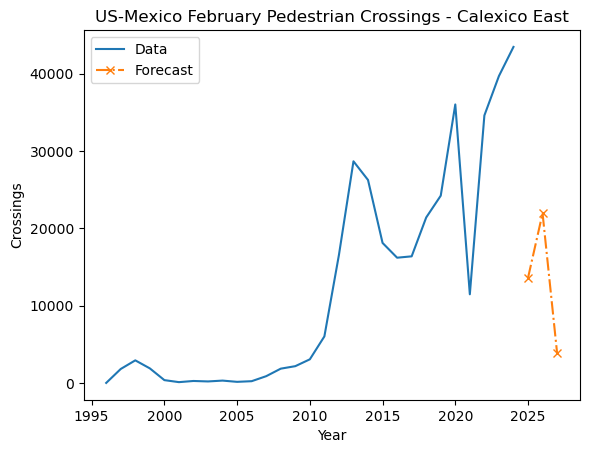

In [94]:
df_0 = df.sort_values(by=['year'])

mex_ped_x = np.asarray(df_0[(df_0['Measure'] == 'pedestrians') & (df_0['Port Code'] == 2507) & (df_0['month'] == 2)]['year'])
mex_ped_y = np.asarray(df_0[(df_0['Measure'] == 'pedestrians') & (df_0['Port Code'] == 2507) & (df_0['month'] == 2)]['Value'])

plt.plot(mex_ped_x, mex_ped_y, label='Data')
plt.plot([2025, 2026, 2027], y_pred_Mex_Ped, linestyle='-.', marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Crossings')
plt.title('US-Mexico February Pedestrian Crossings - Calexico East')
plt.legend()
plt.show()

In [95]:
mex_ped_x[-1]

2024

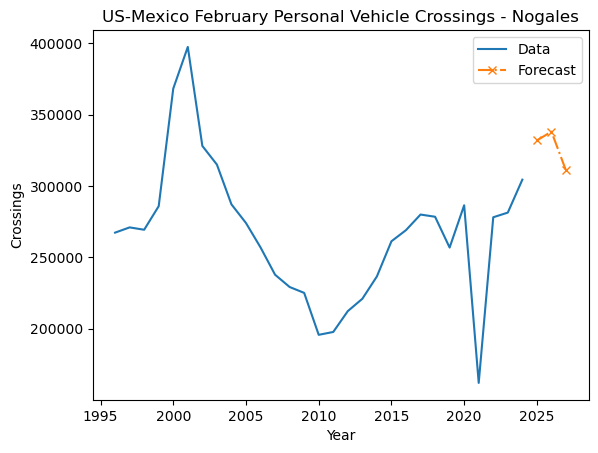

In [96]:
mex_veh_x = np.asarray(df_0[(df_0['Measure'] == 'personal vehicles') & (df_0['Port Code'] == 2604) & (df_0['month'] == 2)]['year'])
mex_veh_y = np.asarray(df_0[(df_0['Measure'] == 'personal vehicles') & (df_0['Port Code'] == 2604) & (df_0['month'] == 2)]['Value'])

plt.plot(mex_veh_x, mex_veh_y, label='Data')
plt.plot([2025, 2026, 2027], y_pred_Mex_Veh, linestyle='-.', marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Crossings')
plt.title('US-Mexico February Personal Vehicle Crossings - Nogales')
plt.legend()
plt.show()

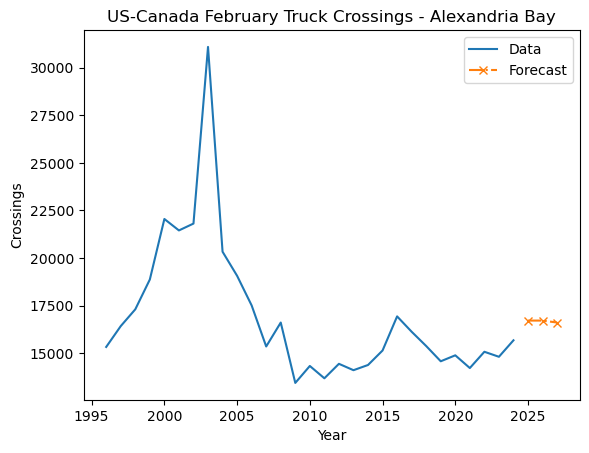

In [97]:
can_tru_x = np.asarray(df_0[(df_0['Measure'] == 'trucks') & (df_0['Port Code'] == 708) & (df_0['month'] == 2)]['year'])
can_tru_y = np.asarray(df_0[(df_0['Measure'] == 'trucks') & (df_0['Port Code'] == 708) & (df_0['month'] == 2)]['Value'])

plt.plot(can_tru_x, can_tru_y, label='Data')
plt.plot([2025, 2026, 2027], y_pred_Can_Tru, linestyle='-.', marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Crossings')
plt.title('US-Canada February Truck Crossings - Alexandria Bay')
plt.legend()
plt.show()

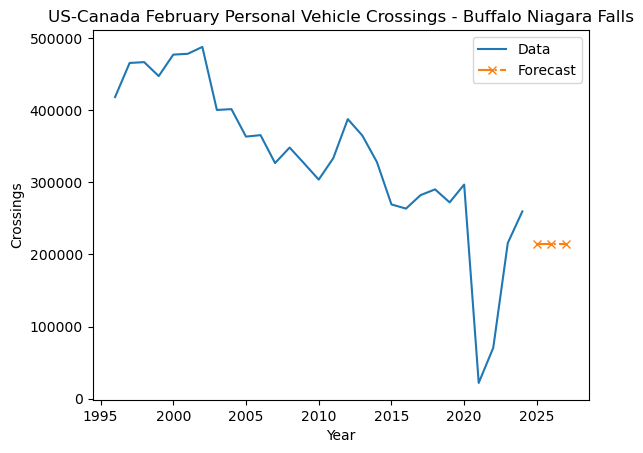

In [98]:
can_veh_x = np.asarray(df_0[(df_0['Measure'] == 'personal vehicles') & (df_0['Port Code'] == 901) & (df_0['month'] == 2)]['year'])
can_veh_y = np.asarray(df_0[(df_0['Measure'] == 'personal vehicles') & (df_0['Port Code'] == 901) & (df_0['month'] == 2)]['Value'])

plt.plot(can_veh_x, can_veh_y, label='Data')
plt.plot([2025, 2026, 2027], y_pred_Can_Veh, linestyle='-.', marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Crossings')
plt.title('US-Canada February Personal Vehicle Crossings - Buffalo Niagara Falls')
plt.legend()
plt.show()

The predicted pedestrians crossings at Port nogales (2604) in February 2026 is 21932


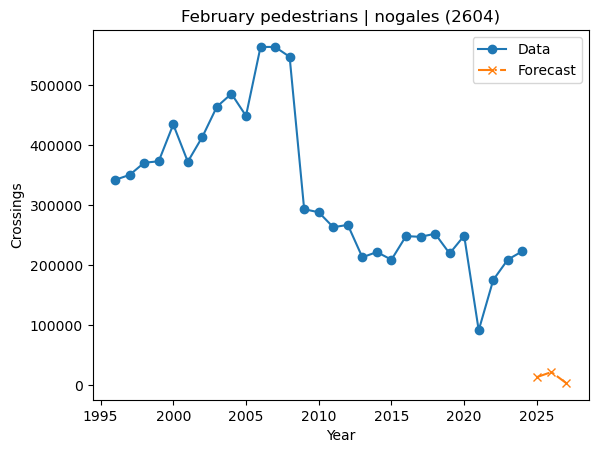

In [100]:
port_code = int(2604)
year = int(2026)
month = int(2)
measure = "pedestrians".lower()
port_name = list(df[df["Port Code"] == port_code]['Port Name'])[0]
state = list(df[df["Port Code"] == port_code]['State'])[0]
lat = float(list(df[df["Port Code"] == port_code]['Latitude'])[0])
long = float(list(df[df["Port Code"] == port_code]['Longitude'])[0])
border = list(df[df["Port Code"] == port_code]['Border'])[0]

# Generate dates and adjust to the 1st of the month
dates = pd.date_range(start=f"{year}-{month}-01", periods=3, freq="12MS") + pd.offsets.Day(-1)
dates = dates + pd.offsets.MonthBegin(+1)  # Adjust to the 1st of each month

# Create the data
data = {
    "Port Name": [port_name] * 3,
    "State": [state] * 3,
    "Port Code": [port_code] * 3,
    "Border": [border] * 3,
    "Date": dates,
    "Measure": [measure] * 3,
    "Latitude": [lat] * 3,
    "Longitude": [long] * 3,
    "month": [month] * 3,
    "year": [2025, 2026, 2027],
}

# Create the DataFrame
df_new = pd.DataFrame(data)
df_new

df_new = df_new.drop(['Port Name', 'Border', 'Measure', 'Date'], axis=1)

# Label encoding on all non-numeric features
le_new = preprocessing.LabelEncoder()

# Select non-numeric features
cols_obj = [col for col in df_new.columns if df_new[col].dtype in ['object']]

for col in cols_obj:
  df_new[col] = le_new.fit_transform(df_new[col])

model = XGBRegressor()

# print(measure, border)
if measure == 'pedestrians':
    df_new = pd.DataFrame(scale(df_new, with_std=True))
    model.load_model("models/XGBR_Mex_Ped.json")
    y_pred = model.predict(df_new)

elif measure == "personal vehicles" and border == "us-canada border":
    df_new = pd.DataFrame(scale(df_new, axis=1, with_std=False))
    model.load_model("models/XGBR_Can_Veh.json")
    y_pred = model.predict(df_new)

elif measure == "personal vehicles" and border == "us-mexico broder":
    df_new = pd.DataFrame(scale(df_new, axis=1, with_std=False))
    model.load_model("models/XGBR_Mex_Veh.json")
    y_pred = model.predict(df_new)

elif measure == "trucks" and border == "us-canada border":
    df_new = pd.DataFrame(scale(df_new, axis=1, with_std=False))
    model.load_model("models/XGBR_Can_Tru.json")
    y_pred = model.predict(df_new)

elif measure == "trucks" and border == "us-mexico border":
    df_new = pd.DataFrame(scale(df_new, axis=1, with_std=False))
    model.load_model("models/XGBR_Mex_Tru.json")
    y_pred = model.predict(df_new)


df_0 = df.sort_values(by=['year'])

x = np.asarray(df_0[(df_0['Measure'] == measure) & (df_0['Port Code'] == port_code) & (df_0['month'] == month)]['year'])
y = np.asarray(df_0[(df_0['Measure'] == measure) & (df_0['Port Code'] == port_code) & (df_0['month'] == month)]['Value'])

month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

print(f"The predicted {measure} crossings at Port {port_name} ({port_code}) in {month_dict[month]} {year} is {round(y_pred[year % 2025])}")

plt.plot(x, y, label='Data', marker='o')
plt.plot([2025, 2026, 2027], y_pred, linestyle='-.', marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Crossings')
plt.title(f'{month_dict[month]} {measure} | {port_name} ({port_code})')
plt.legend()
plt.show()